In [93]:
# Load libraries.
import pandas as pd
import numpy as np

# Visualisation libraries.
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import KNNImputer # You will need the scikit-learn version >= 0.22
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch

### Explore the data

In [94]:
# Load dataset and use the country column as index.
df = pd.read_csv("UsArrests.csv")
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [95]:
# Count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


This is great because as we can see there is no missing values

In [96]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [97]:
corr_matrix = df[["Murder", "Assault", "UrbanPop", "Rape"]].corr()

# Display the correlation matrix
print(corr_matrix)

            Murder   Assault  UrbanPop      Rape
Murder    1.000000  0.801873  0.069573  0.563579
Assault   0.801873  1.000000  0.258872  0.665241
UrbanPop  0.069573  0.258872  1.000000  0.411341
Rape      0.563579  0.665241  0.411341  1.000000


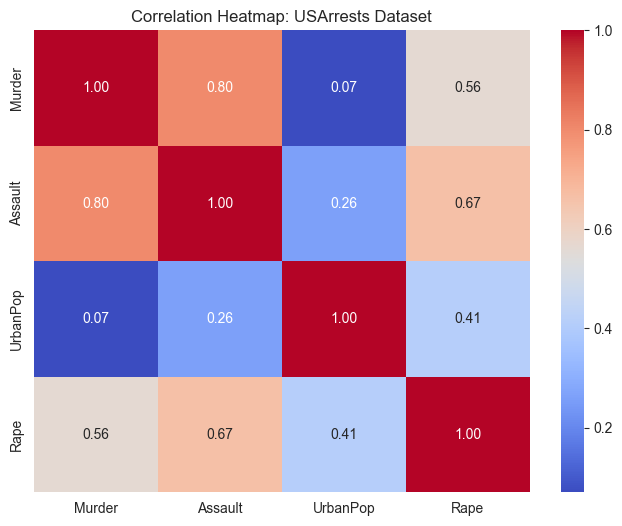

In [98]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: USArrests Dataset")
plt.show()

Based on the plot above, the two features that correlated the most are assault and murder for US arrests.

### PCA

In [99]:
# Numeric columns
X = df[["Murder", "Assault", "UrbanPop", "Rape"]]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# New DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2","PC3", "PC4"], index=df.index)

# Display the first few rows
pca_df.head()

,PC1,PC2,PC3,PC4
0,0.985566,-1.133392,-0.444269,-0.156267
1,1.950138,-1.073213,2.040003,0.438583
2,1.763164,0.745957,0.054781,0.834653
3,-0.141420,-1.119797,0.114574,0.182811
4,2.523980,1.542934,0.598557,0.341996


In [100]:
variance_ratio = pca.explained_variance_ratio_
print("Explained variance by component:")
for i, var in enumerate(variance_ratio, 1):
    print(f"PC{i}: {var:.2%}")

Explained variance by component:
PC1: 62.01%
PC2: 24.74%
PC3: 8.91%
PC4: 4.34%


I will be choosing PC1 and PC2 to further my analysis. Both components account for about 87% of the total variance, which is sufficiently high to represent the original dataset with minimal information loss.

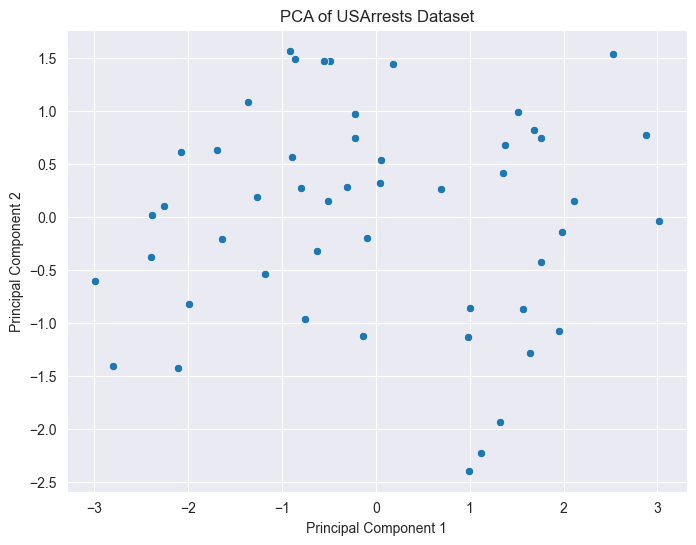

In [104]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2")
plt.title("PCA of USArrests Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

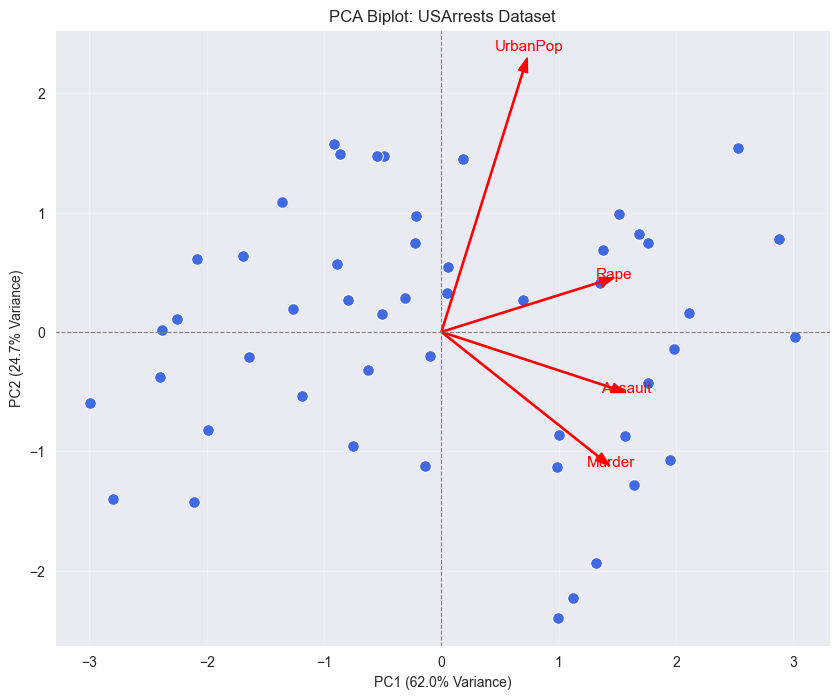

In [106]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# DataFrame for PCA results
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df.index)

# Create biplot
plt.figure(figsize=(10, 8))

# Scatter plot of samples (
sns.scatterplot(
    data=pca_df, x="PC1", y="PC2",
    s=70, color="royalblue", edgecolor="white"
)

# Plot feature vectors
loadings = pca.components_.T
for i, var in enumerate(X.columns):
    plt.arrow(0, 0, loadings[i, 0]*2.5, loadings[i, 1]*2.5,
              color='red', width=0.01, head_width=0.08)
    plt.text(loadings[i, 0]*2.7, loadings[i, 1]*2.7, var, color='red', ha='center', fontsize=11)

# Labels and aesthetics
plt.title("PCA Biplot: USArrests Dataset")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)")
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.axvline(0, color="gray", linestyle="--", linewidth=0.8)
plt.grid(alpha=0.3)
plt.show()

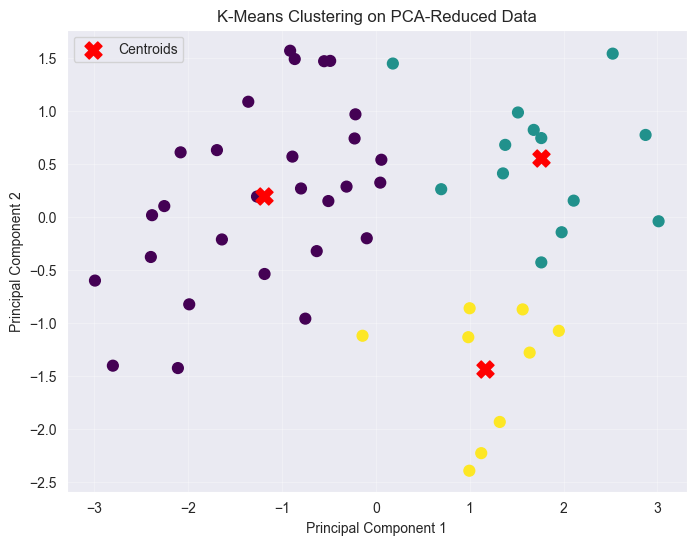

In [61]:
# Create a new DataFrame with PC1 and PC2
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df.index)

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df_pca["KMeans_Cluster"] = kmeans.fit_predict(df_pca)

# Plot KMeans clusters
plt.figure(figsize=(8,6))
plt.scatter(df_pca["PC1"], df_pca["PC2"], c=df_pca["KMeans_Cluster"], cmap="viridis", s=60)
plt.title("K-Means Clustering on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=150, marker='X', label='Centroids')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

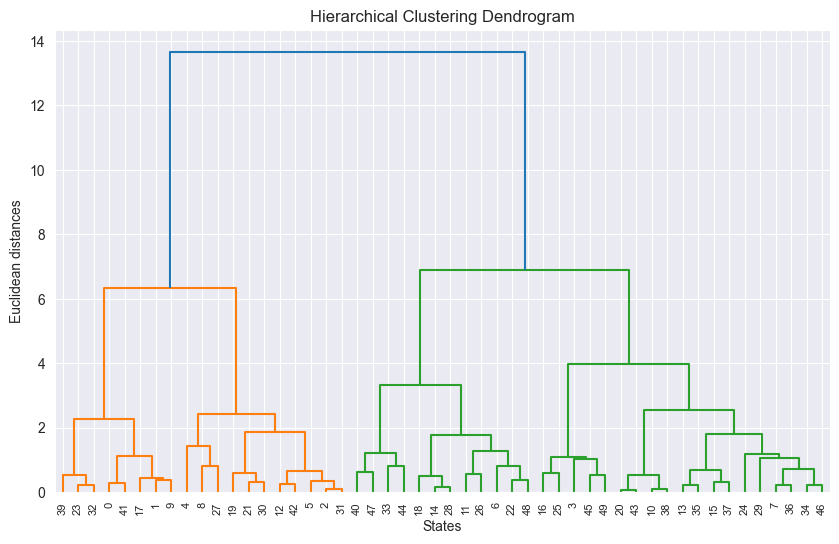

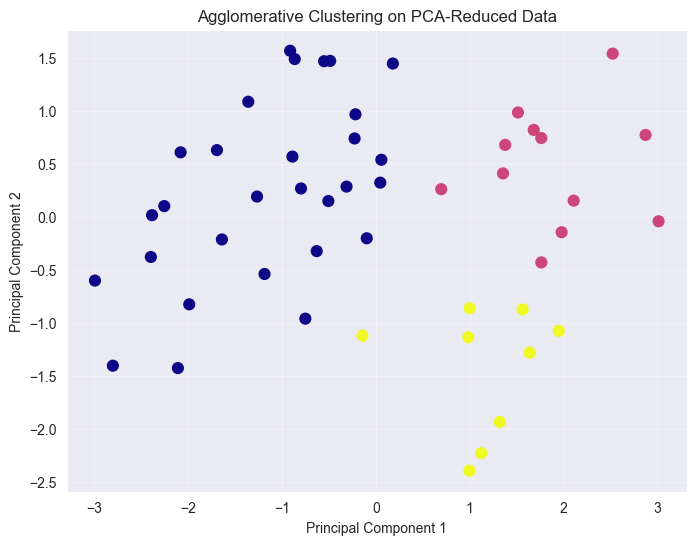

In [69]:
# Dendrogram
plt.figure(figsize=(10,6))
dendrogram = sch.dendrogram(sch.linkage(df_pca[["PC1", "PC2"]], method='ward'))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("States")
plt.ylabel("Euclidean distances")
plt.show()

# Apply Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=3)
df_pca["Agglomerative_Cluster"] = agg.fit_predict(df_pca)

# Plot results
plt.figure(figsize=(8,6))
plt.scatter(df_pca["PC1"], df_pca["PC2"], c=df_pca["Agglomerative_Cluster"], cmap="plasma", s=60)
plt.title("Agglomerative Clustering on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(alpha=0.3)
plt.show()

### Comparison between K-Means and Agglomerative

K-Means is effective for quick, well-separated clustering and gives clear positions. Agglomerative Clustering provides a hierarchical view (via the dendrogram), revealing how states merge based on distance and similarity. Points within each cluster are close together in PCA space meaning they have similar combinations of murder, assault, rape, and urban population rates. The distance between clusters indicates clear differences in crime profiles among groups of states. This similarity within clusters and separation between them suggests that the clustering effective